In [1]:
from scipy.stats import bernoulli
from functions import read_input_data, cal_income
from constants import education_level, MU, RETIRE_AGE, START_AGE, unempl_rate, unemp_frac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
income_fp = './data/age_coefficients_and_var.xlsx'
mortal_fp = './data/Conditional Survival Prob Feb 16.xlsx'
age_coeff, std, surv_prob = read_input_data(income_fp, mortal_fp)
print(age_coeff)
print('\n')
print(std.loc[:, 'Labor Income Only'])

                              a         b1         b2        b3
No High School         41078.88 -2201.5820  78.223410 -0.788948
High School Graduates  28752.76  -917.5466  51.095140 -0.608928
College Graduates     -51819.03  3553.4590   0.933759 -0.549925


                  No High School  High School Graduates  College Graduates
sigma_permanent         0.157162               0.137113           0.143875
sigma_transitory        0.339190               0.233773           0.229565


## Income Process for College Students [excel output]

In [28]:
N_SIM = 10000
AltDeg = 1
income = cal_income(age_coeff, AltDeg, True)
sigma_perm = std.loc['sigma_permanent', 'Labor Income Only'][education_level[AltDeg]]
sigma_tran = std.loc['sigma_transitory', 'Labor Income Only'][education_level[AltDeg]]

In [29]:
# generate random walk and normal r.v.
rn_perm = np.random.normal(MU, sigma_perm, (N_SIM, RETIRE_AGE - START_AGE + 1))
rand_walk = np.cumsum(rn_perm, axis=1)
rn_tran = np.random.normal(MU, sigma_tran, (N_SIM, RETIRE_AGE - START_AGE + 1))
inc_with_inc_risk = np.multiply(np.exp(rand_walk) * np.exp(rn_tran), income)

In [30]:
inc_with_inc_risk.shape

(10000, 44)

In [31]:
# generate bernoulli random variable 
p = 1- unempl_rate[AltDeg]
r = bernoulli.rvs(p, size=(44, N_SIM)).astype(float)
r[r==0] = unemp_frac[AltDeg]

In [32]:
r.shape # 44 bernoulli r.v., each with 10000 randome variates 

(44, 10000)

In [21]:
# output
inc_proc = np.multiply(inc_with_inc_risk, r.T)
df = pd.DataFrame(inc_proc)
df.to_excel('income_process.xlsx', index=False)

In [22]:
# sanity check: at each age, the unemployment rate is around 0.0738
(inc_proc[:, 2] < inc_with_inc_risk[:, 2]).sum() / N_SIM

0.20330000000000001

## Income Process for all 3 groups [22+]

In [3]:
ave_inc_proc = pd.DataFrame(np.zeros((44, 0)))
for AltDeg in [1, 2, 4]:
    N_SIM = 100000
    income = cal_income(age_coeff, AltDeg, True)
    sigma_perm = std.loc['sigma_permanent', 'Labor Income Only'][education_level[AltDeg]]
    sigma_tran = std.loc['sigma_transitory', 'Labor Income Only'][education_level[AltDeg]]

    rn_perm = np.random.normal(MU, sigma_perm, (N_SIM, RETIRE_AGE - START_AGE + 1))
    rand_walk = np.cumsum(rn_perm, axis=1)
    rn_tran = np.random.normal(MU, sigma_tran, (N_SIM, RETIRE_AGE - START_AGE + 1))
    inc_with_inc_risk = np.multiply(np.exp(rand_walk) * np.exp(rn_tran), income)

    p = 1 - unempl_rate[AltDeg]  # 1 - pi 
    r = bernoulli.rvs(p, size=(44, N_SIM)).astype(float)
    r[r==0] = unemp_frac[AltDeg]  # theta 

    inc_proc = np.multiply(inc_with_inc_risk, r.T)
    df = pd.DataFrame(inc_proc)
    ave_inc_proc.loc[:, AltDeg] = df.mean()


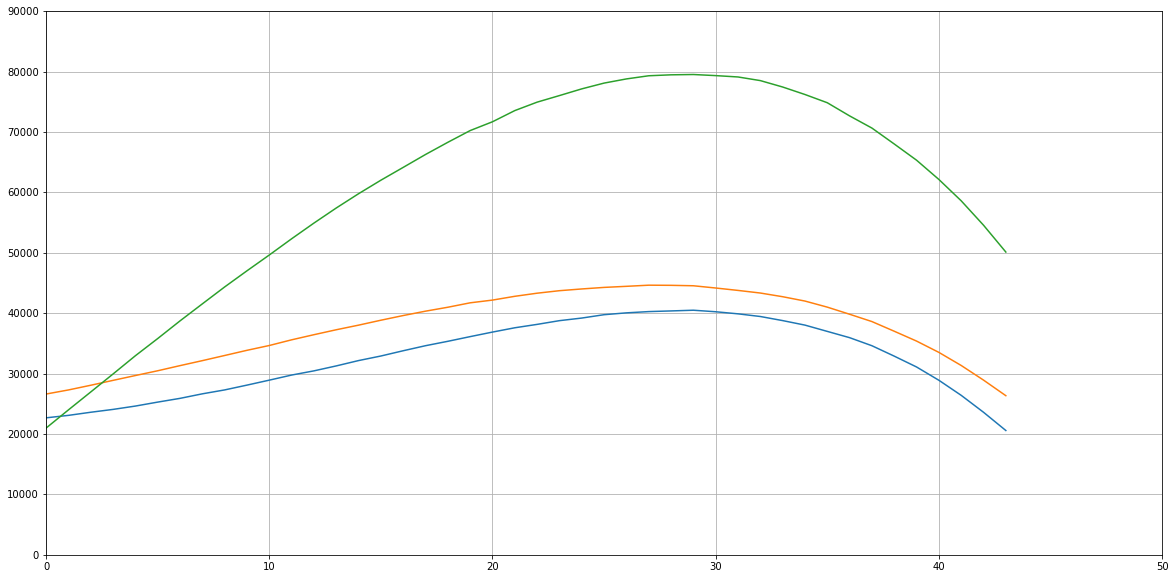

In [4]:
plt.figure(figsize=(20,10))
plt.plot(ave_inc_proc)
plt.ylim(0, 90000)
plt.xlim(0, 50)
plt.grid()
plt.show()

## Income Process for all 3 groups [20+]

(46,)
(46,)


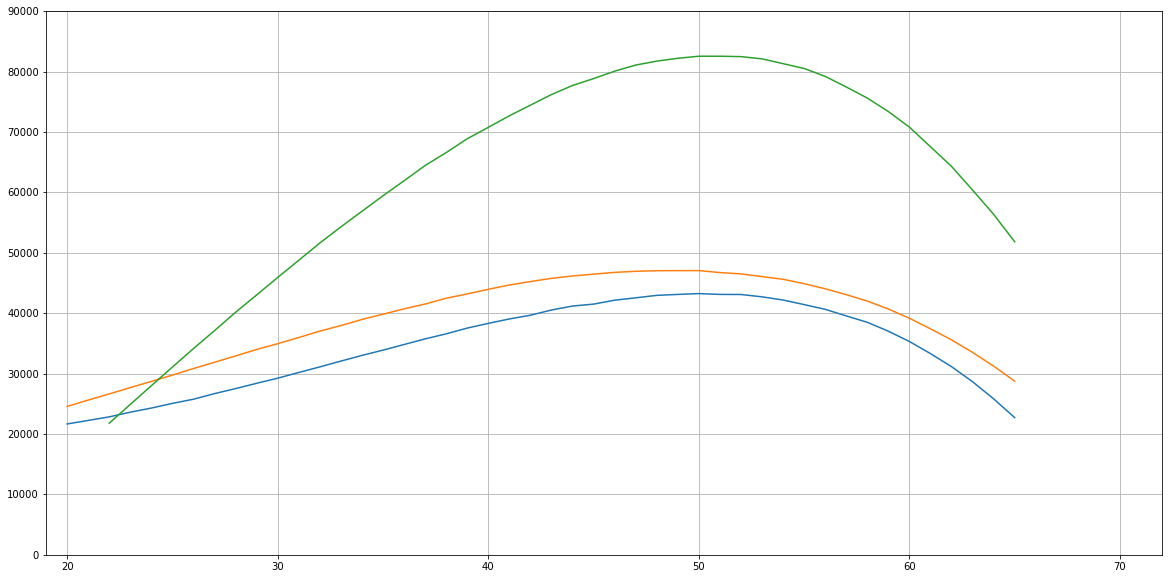

In [33]:
plt.figure(figsize=(20,10))
plt.ylim(0, 90000)
plt.xlim(19, 72)
plt.grid()

N_SIM = 100000

for AltDeg in [1, 2, 4]:
    if AltDeg == 1 or AltDeg == 2:
        START_AGE = 20
    else:
        START_AGE = 22
    
    coeff_this_group = age_coeff.loc[education_level[AltDeg]]
    a  = coeff_this_group['a']
    b1 = coeff_this_group['b1']
    b2 = coeff_this_group['b2']
    b3 = coeff_this_group['b3']
    ages = np.arange(START_AGE, RETIRE_AGE+1)
    income = (a + b1 * ages + b2 * ages**2 + b3 * ages**3)
    
    sigma_perm = std.loc['sigma_permanent', 'Labor Income Only'][education_level[AltDeg]]
    sigma_tran = std.loc['sigma_transitory', 'Labor Income Only'][education_level[AltDeg]]

    rn_perm = np.random.normal(MU, sigma_perm, (N_SIM, RETIRE_AGE - START_AGE + 1))
    rand_walk = np.cumsum(rn_perm, axis=1)
    rn_tran = np.random.normal(MU, sigma_tran, (N_SIM, RETIRE_AGE - START_AGE + 1))
    inc_with_inc_risk = np.multiply(np.exp(rand_walk) * np.exp(rn_tran), income)

    p = 1 - unempl_rate[AltDeg]  # 1 - pi 
    r = bernoulli.rvs(p, size=(RETIRE_AGE - START_AGE + 1, N_SIM)).astype(float)
    r[r==0] = unemp_frac[AltDeg]  # theta 

    inc_proc = np.multiply(inc_with_inc_risk, r.T)
    df = pd.DataFrame(inc_proc)
    ave_inc_proc = df.mean()
    
    if AltDeg == 1 or AltDeg == 2:
        print(ave_inc_proc.shape)
        plt.plot(np.arange(20, 66), ave_inc_proc)
    else:
        plt.plot(np.arange(22, 66), ave_inc_proc)

plt.show()

## Income Process for all 3 groups [20+ & spiky]

(46,)
(46,)


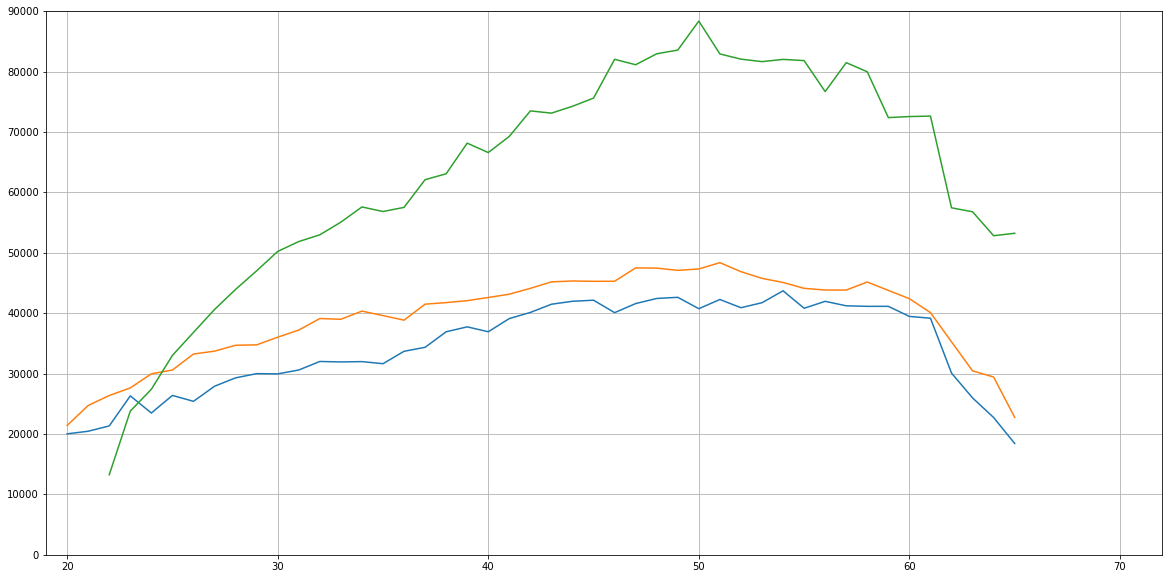

In [3]:
plt.figure(figsize=(20,10))
plt.ylim(0, 90000)
plt.xlim(19, 72)
plt.grid()

N_SIM = 10000

determ_inc_fp = './data/Reg1Predicted.xlsx'
income_df = pd.read_excel(determ_inc_fp)

for AltDeg in [1, 2, 4]:
    if AltDeg == 1 or AltDeg == 2:
        START_AGE = 20
    else:
        START_AGE = 22
    
    income = income_df.loc[income_df['AltDeg'] == AltDeg, 'e(Labor Income)'].values
    
    sigma_perm = std.loc['sigma_permanent', 'Labor Income Only'][education_level[AltDeg]]
    sigma_tran = std.loc['sigma_transitory', 'Labor Income Only'][education_level[AltDeg]]

    rn_perm = np.random.normal(MU, sigma_perm, (N_SIM, RETIRE_AGE - START_AGE + 1))
    rand_walk = np.cumsum(rn_perm, axis=1)
    rn_tran = np.random.normal(MU, sigma_tran, (N_SIM, RETIRE_AGE - START_AGE + 1))
    inc_with_inc_risk = np.multiply(np.exp(rand_walk) * np.exp(rn_tran), income)

#     p = 1 - unempl_rate[AltDeg]  # 1 - pi 
#     r = bernoulli.rvs(p, size=(RETIRE_AGE - START_AGE + 1, N_SIM)).astype(float)
#     r[r==0] = unemp_frac[AltDeg]  # theta 

#     inc_proc = np.multiply(inc_with_inc_risk, r.T)
    df = pd.DataFrame(inc_with_inc_risk)
    ave_inc_proc = df.mean()
    
    if AltDeg == 1 or AltDeg == 2:
        print(ave_inc_proc.shape)
        plt.plot(np.arange(20, 66), ave_inc_proc)
    else:
        plt.plot(np.arange(22, 66), ave_inc_proc)

plt.show()

## Income Process for College Students [spiky]

In [76]:
# read deterministic component of income from excel
determ_inc_fp = './data/determ_comp_inc.xlsx'
income = pd.read_excel(determ_inc_fp)['Y-hat'].values
# income.plot()
# plt.show()

In [77]:
AltDeg = 4
N_SIM = 10000
sigma_perm = std.loc['sigma_permanent', 'Labor Income Only'][education_level[AltDeg]]
sigma_tran = std.loc['sigma_transitory', 'Labor Income Only'][education_level[AltDeg]]

rn_perm = np.random.normal(MU, sigma_perm, (N_SIM, RETIRE_AGE - START_AGE + 1))
rand_walk = np.cumsum(rn_perm, axis=1)
rn_tran = np.random.normal(MU, sigma_tran, (N_SIM, RETIRE_AGE - START_AGE + 1))
inc_with_inc_risk = np.multiply(np.exp(rand_walk) * np.exp(rn_tran), income)

p = 1- unempl_rate[AltDeg]
r = bernoulli.rvs(p, size=(44, N_SIM)).astype(float)
r[r==0] = unemp_frac[AltDeg]

inc_proc = np.multiply(inc_with_inc_risk, r.T)
df = pd.DataFrame(inc_proc)

# plt.figure(figsize=(20,10))
# plt.plot(df.mean())
# plt.ylim(0, 90000)
# plt.xlim(0, 50)
# plt.grid()
# plt.show()

df.to_excel('income_process_spiky.xlsx', index=False)

## Just the age poly

28533.7718312
35442.2483875
60161.333475


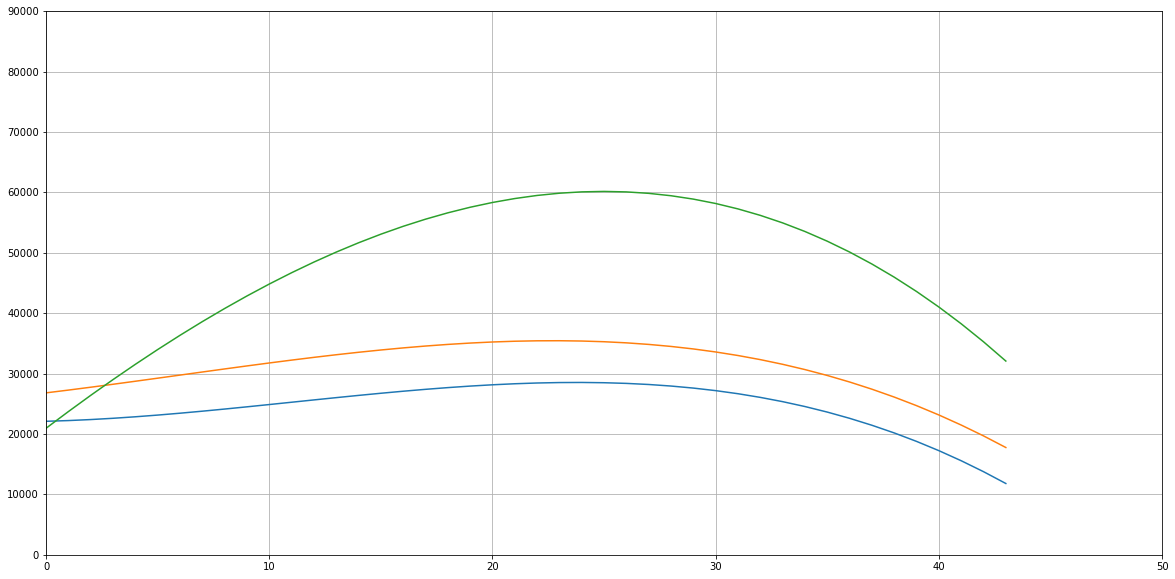

In [83]:
plt.figure(figsize=(20,10))
plt.ylim(0, 90000)
plt.xlim(0, 50)
plt.grid()
for AltDeg in [1, 2, 4]:
    N_SIM = 10000
    income = cal_income(age_coeff, AltDeg, True)
    print(income.max())
    plt.plot(income)
plt.show()